In [1]:
# This is for Kaggle notebook.
# import module we'll need to import our custom module
from shutil import copytree

# copy our file into the working directory (make sure it has .py suffix)
copytree(src = "../input/myfedprox/MyFedProx/", dst = "../working/MyFedProx")

'../working/MyFedProx'

In [2]:
from MyFedProx.CNN import CNN
from MyFedProx.federated_learning import *
from MyFedProx.dataset_splits import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch
import numpy as np
from torchvision.models import mobilenet_v2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
train_loader, test_loader = get_SIIM_ISIC("/kaggle/input/siim-isic-melanoma-classification/jpeg/train/", "/kaggle/input/siim-isic-melanoma-classification/train.csv",type="fair", train_size=0.8, test_size=0.2, batch_size=32, device=device, total_size=None, resnet50=True, balanced=True)

<torch.utils.data.dataset.Subset object at 0x793fc150ace0> <torch.utils.data.dataset.Subset object at 0x793fc150a7a0>


In [5]:
#Let's take a look at the class repartition in each clients
for i, loader in enumerate(train_loader):
    it = iter(loader)
    benign = 0
    malignant = 0
    for data, labels in it:
        for label in labels:
            if np.argmax(label.cpu()) == 1:
                malignant += 1
            else:
                benign += 1
    print(f"Client {i}:")
    print("Malignant: ", malignant)
    print("Benign: ", benign)
    print("Rate: ", malignant/(malignant+benign))

Client 0:
Malignant:  161
Benign:  151
Rate:  0.5160256410256411
Client 1:
Malignant:  159
Benign:  153
Rate:  0.5096153846153846
Client 2:
Malignant:  160
Benign:  151
Rate:  0.5144694533762058


In [6]:
model = mobilenet_v2(pretrained=True).to(device)
model.classifier[1] = torch.nn.Linear(1280, 2).to(device)
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
#model = CNN().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 66.7MB/s]


In [7]:
model, loss_acc, hist_acc = FedProx(model, train_loader,n_iter=10,  testing_sets=test_loader,  epochs=2, mu=0.3)

Clients' weights: [0.3336898395721925, 0.3336898395721925, 0.332620320855615]
====> i: 0 Loss: 0.7289558274860688 Server Test Accuracy: 47.783617543779116
====> i: 1 Loss: 0.511828647960316 Server Test Accuracy: 73.24826145830943
====> i: 2 Loss: 0.5340339287717075 Server Test Accuracy: 76.96633081636868
====> i: 3 Loss: 0.7690079721537504 Server Test Accuracy: 74.10433545247986
====> i: 4 Loss: 0.7377445901778931 Server Test Accuracy: 70.52902159693375
====> i: 5 Loss: 0.5488326666189387 Server Test Accuracy: 76.25163526198618
====> i: 6 Loss: 0.9092572126159055 Server Test Accuracy: 67.95437332170481
====> i: 7 Loss: 0.6650087565661751 Server Test Accuracy: 71.67336072158088
====> i: 8 Loss: 0.5407156748248931 Server Test Accuracy: 74.96454063482591
====> i: 9 Loss: 0.5435438857996528 Server Test Accuracy: 74.81994904867918
====> i: 10 Loss: 0.4275442720097017 Server Test Accuracy: 77.11184044433224


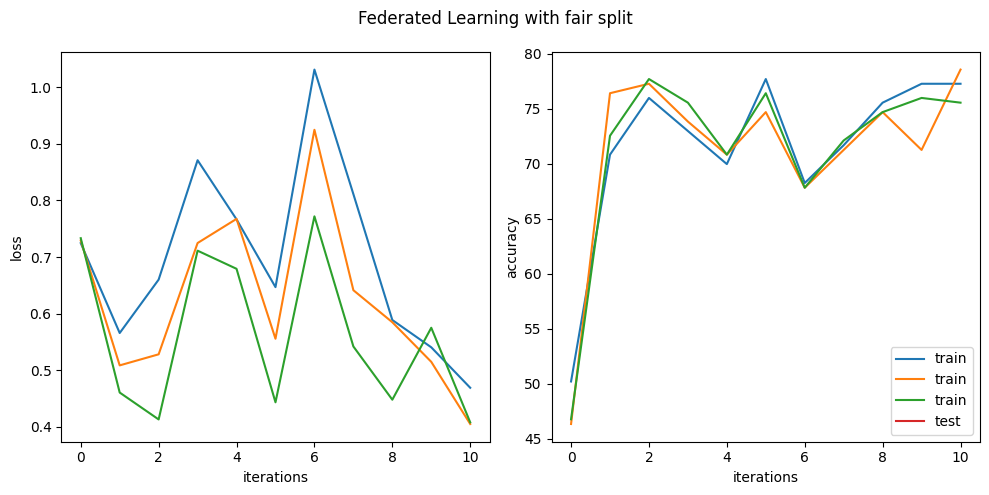

In [8]:
plot_acc_loss("Federated Learning with fair split", hist_acc, [], loss_acc)

In [9]:
torch.save(model.state_dict(), "model_fair_split.pt")